### Pilot Bootstrap for LTP RCA EEG

In [85]:
# load packages
import numpy as np 
import scipy.io
from scipy.fft import fft, ifft
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
np.random.seed(9191977) # set seed number

#### Set Main Dir and 2 ImportFile Dirs ...

In [86]:
# Main Directory of processed file from MatLab
MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\RCA\\' # set dir
SaveFigDir = 'D:\\AttnXV3_analysis\\F1NRushPlots\\' # set dir where imgs will be saved
os.chdir(MainDir)
# Set File Name 
d = os.listdir(MainDir) # list files in dir
FileN = (d[0]) # choose one
file_path = os.path.join(MainDir, FileN) # join paths and prep 2 load
print(file_path) # does path exist ... ?
print(os.path.exists(file_path)) # yes or no
print(SaveFigDir) 
print(os.path.exists(SaveFigDir))

D:\AttnXV3_analysis\RCA_F1\RCA\rcaResults_Sweep_contrast_sweeps.mat
True
D:\AttnXV3_analysis\F1NRushPlots\
True


In [87]:
# Load CRF File
InDataDir1 = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where avg crf were be saved
FileOps = os.listdir(InDataDir1) # list files in dir
print(FileOps) #list file names .. too long to type out
###################
dataIn = FileOps[4]
print('Selected File:', dataIn)
ImportFile_crf = os.path.join(InDataDir1,dataIn)
print(ImportFile_crf)
print('Does File Exist?', os.path.exists(ImportFile_crf))

['F1AverageCRF_20240205_154708.pkl', 'F1AverageCRF_20240205_162024.mat', 'F1AverageCRF_20240205_162024.pkl', 'F1AverageCRF_20240206_104806.pkl', 'F1AverageCRF_20240207_124816.pkl']
Selected File: F1AverageCRF_20240207_124816.pkl
D:\AttnXV3_analysis\RCA_F1\AvgCRFs\F1AverageCRF_20240207_124816.pkl
Does File Exist? True


In [88]:
# Load NR Params File
InDataDir2 = 'D:\\AttnXV3_analysis\\RCA_F1\\HyperRatio_Params\\' # set dir where avg crf were be saved
FileOps = os.listdir(InDataDir2) # list files in dir
print(FileOps) #list file names .. too long to type out
###################
dataIn = FileOps[3]
print('Selected File:', dataIn)
ImportFile_nr = os.path.join(InDataDir2,dataIn)
print(ImportFile_nr)
print('Does File Exist?', os.path.exists(ImportFile_nr))

['F1_NR_Params_ns_20240207_140807.pkl', 'F1_NR_Params_20240207_141259.pkl', 'F1_ns_NR_Params_20240207_154757.pkl', 'F1_NR_Params_20240207_165458.pkl']
Selected File: F1_NR_Params_20240207_165458.pkl
D:\AttnXV3_analysis\RCA_F1\HyperRatio_Params\F1_NR_Params_20240207_165458.pkl
Does File Exist? True


#### Set Global Params

In [107]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
contrast_levels = np.array([1, 3, 5, 16, 40, 100])
cLabs=['1%', '3%', '5%', '16%', '40%', '100%']
soi = 21 # subjects data to look at 
NumBoots = 1000 # number of shuffling arrays we will have and then plot

#### Functions 

In [90]:
def CleanRCA(x): # replace 0's in data with nan's
    x[x == 0] = np.nan
    return x
##############################################################################
# shuffle data before real and imaginary numbers are combined
def ShuffleTrials(x, NumComp):
    x = np.array(x) # set data as array
    x = x[:,NumComp,:] # get # component we want
    shuff_data = np.ones_like(x) # copy of 24 x 78
    [NumRows, NumTrials] = x.shape # 24 x 78
    TrialInd = np.array(np.arange(0,NumTrials,1)) # array =len of #Trials
    #index = np.random.shuffle(TrialInd)  # random sampling without replacement - just shuffling 
    index = np.random.randint(0,NumTrials,NumTrials) # index position (# trial) # random sampling with replacement 
    NewTrialList = TrialInd[index] # shuffled pos array
    shuff_data = x[:,NewTrialList] # set rando samp w replacment
    return shuff_data # 24 x 78 array (only want 1st rca component)
################################################################################
# comine real and imaginary numbers after shuffling, only 1st component
def CombineRealImg(x, NumHarms):
    [NumCols, NumTrials] = np.shape(x) # 24 x 78-80
    DomainCutoff = int(NumCols/NumHarms) # use to index cutoff  - float -> int
    CondCutoff = int(NumTrials/2) # 39 - 40 depends...
    pre = x[:,:CondCutoff] # 24 x 39 - 40 depends ...
    post = x[:,CondCutoff:]
    AmpPerBin = np.ones((DomainCutoff,NumHarms)) # [bins (2f1 then 4f1)] X [pre /post] \ 12 x 2
    for RowInd in range(DomainCutoff):
        ################ combining data generated from real and imaginary comp (1st half of cols and last half)
        AmpPerBin[RowInd,0] = np.hypot(np.nanmean(pre[RowInd,:]),np.nanmean(pre[RowInd+DomainCutoff,:])) # 12 x 78 PRE
        AmpPerBin[RowInd,1] = np.hypot(np.nanmean(post[RowInd,:]),np.nanmean(post[RowInd+DomainCutoff,:])) # 12 x 78 POST
    return AmpPerBin
#################################################################################

### Load data

In [91]:
mat_data = scipy.io.loadmat(file_path)
rca = mat_data['rcaResult']['projectedData'][0,0]
rcaData = [rca[i,0] for i in range(rca.shape[0])] # final data output

In [92]:
# load crf data
loadData = pkl.load(open(ImportFile_crf, 'rb'))
print(loadData.keys())
crf = loadData['OriginalCRF']
ns_crf = loadData['NoSatCRF']
#avg_crf = loadData['avgCRF']
#avg_crf_ns = loadData['NoSatavgCRF']
FName =  loadData['FileNames']
NumSubs = int(len(crf.keys()))

dict_keys(['OriginalCRF', 'NoSatCRF', 'avgCRF', 'NoSatavgCRF', 'FileNames'])


In [93]:
allCRF = dict()

for i in range(NumSubs):
    data = crf[i]
    [cols, rows] = data.shape
    crfs = np.zeros((int(rows*2),int(cols/2)))
    # Pre Data
    crfs[0,:] = data[:6,0] # 2F
    crfs[1,:] = data[6:,0] # 4F
    # Post Data
    crfs[2,:] = data[:6,1] # 2F
    crfs[3,:] = data[6:,1] # 4F

    allCRF[i] = crfs # 4 x 6 array

In [94]:
# Get subject names
#SubNames = mat_data['rcaResult'][0,0][5]
#FileName = [x[0][3:] for subjlist in SubNames for x in subjlist[0][2][0]]
#print(len(FileName))
#print(FileName[soi])

### Step 1: Replace 0's with Nan's

In [95]:
rca = dict()
for k in range(len(rcaData)):
    rca[k] = CleanRCA(rcaData[k])

### Step 2 : Shuffle Data Across Trials

In [96]:
shuffs = dict()
for j in range(NumBoots):
    shuffs[j] = ShuffleTrials(rca[soi], NumComp)
    #print(shuffs[j][0,0:2])

### Step 3: Combine Real and Imaginary components from RCA Sweep
#### From Real RCA Data ...

[ 0.32799939  0.41597075  0.83664917  0.98050464  0.6130247   0.71357014
 -0.04003149 -0.19172552 -0.00992156  0.11990477  0.6204895   0.9348629 ]


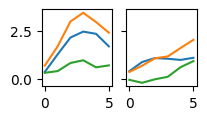

In [97]:
o = allCRF[soi]
fig, axs = plt.subplots(1,2,figsize = (2,1), sharey = True)
real_diff1 = o[2,:] - o[0,:]
real_diff2 =  o[3,:] - o[1,:]
axs[0].plot(o[0,:])
axs[0].plot(o[2,:])
axs[0].plot(real_diff1)
axs[1].plot(o[1,:])
axs[1].plot(o[3,:])
axs[1].plot(real_diff2)
#print(real_diff1,real_diff2)
real_diff = np.hstack((real_diff1,real_diff2))
print(real_diff)

#y = rca[soi][:,NumComp,:] # 3 dim array
#real_rca = CombineRealImg(y, NumHarms) # only takes 2 dim array
#real_diff =  real_rca[:,1] - real_rca[:,0] # 12 array diff : post - pre
#print(real_diff)

#### ... And Permuted Data

In [98]:
psuedo_rca = dict()
for pdata in range(len(shuffs.keys())):
    psuedo_rca[pdata] = CombineRealImg(shuffs[pdata], NumHarms) # amplitude per bin per harmonic [12 x 2]
    #print(np.shape(psuedo_rca[pdata])) # shape
    #print(psuedo_rca[pdata][0:3,0]) # data generated

### Step 4: Find difference in amplitude between Post and Pre ...
#### ... and store in big array

In [99]:
pseudo_rca_diffs = np.ones((int(len(shuffs.keys())),NumBins*2)) # iteration x difference generated from pre/postharmonic

for d in range(len(shuffs.keys())):
    data = psuedo_rca[d] # 12 x 2 
    AmpDiff_Ind = data[:,1] - data[:,0]
    pseudo_rca_diffs[d,:] = AmpDiff_Ind # 12 int array

print('Number of Iters and Bin Nums:', pseudo_rca_diffs.shape) # numIters x 12 frequency labels we have  - still 0:6 2F1, 6: 4F1 

Number of Iters and Bin Nums: (1000, 12)


DescribeResult(nobs=1000, minmax=(-0.6692036674347416, 0.6726736881184205), mean=0.0022360246382810097, variance=0.04538988516027206, skewness=0.023610356206403785, kurtosis=0.24994636291046568)
SEM:  0.0067372015822796975


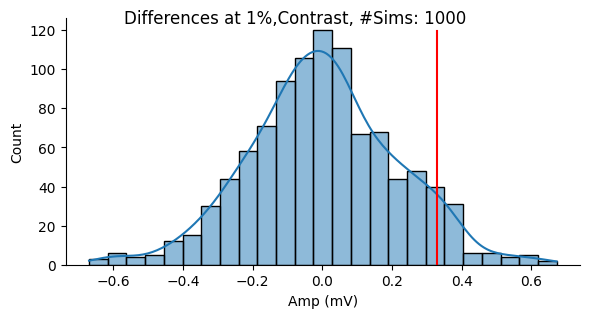

DescribeResult(nobs=1000, minmax=(-0.7147114155203642, 0.8004993002009946), mean=0.0017277183990419252, variance=0.05295995184515547, skewness=0.08080417741459163, kurtosis=0.15198632594626726)
SEM:  0.007277358850926307


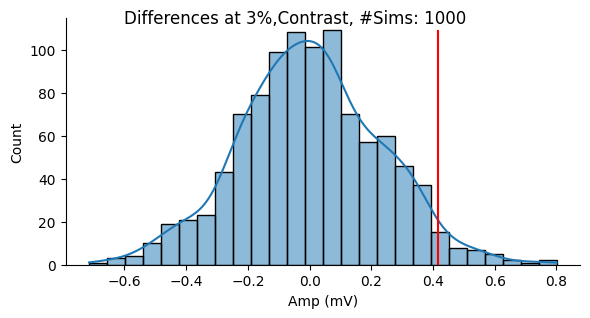

DescribeResult(nobs=1000, minmax=(-0.6141454981977494, 0.7080456404624775), mean=-0.004892325515426293, variance=0.048427245891330656, skewness=0.13508175239475761, kurtosis=-0.18043657661222223)
SEM:  0.006958968737631364


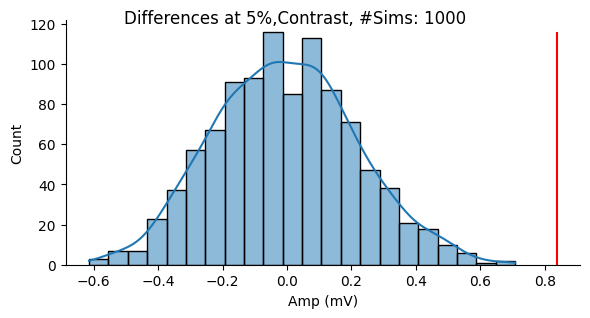

DescribeResult(nobs=1000, minmax=(-0.6934900285885801, 0.8381203944079232), mean=-0.012395442810404769, variance=0.04639341357128338, skewness=-0.018097042029434757, kurtosis=-0.12948911207110259)
SEM:  0.006811271068698072


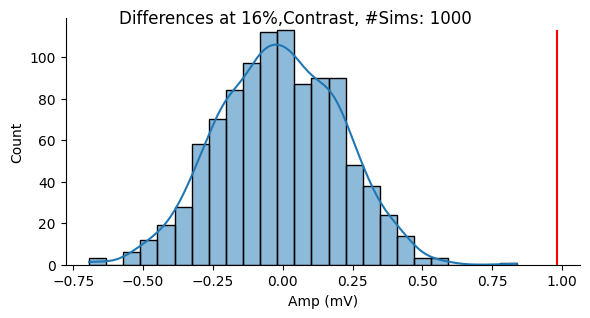

DescribeResult(nobs=1000, minmax=(-0.5343054806969558, 0.5325299710962303), mean=-0.00762899161820489, variance=0.03189080146939726, skewness=-0.05478124593538096, kurtosis=-0.03615954920526754)
SEM:  0.005647194123580068


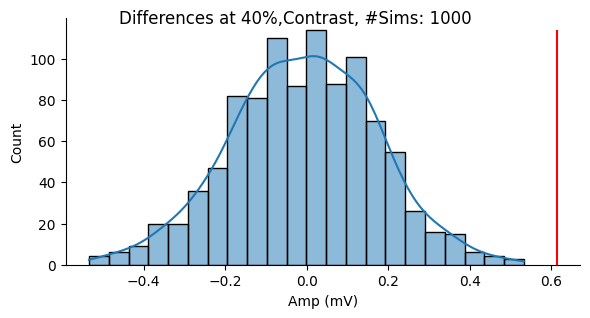

DescribeResult(nobs=1000, minmax=(-0.6165641477336228, 0.6588542242584392), mean=-0.0038423153776454234, variance=0.043640472466271264, skewness=0.05255973571403688, kurtosis=0.006652877377487876)
SEM:  0.006606093585945575


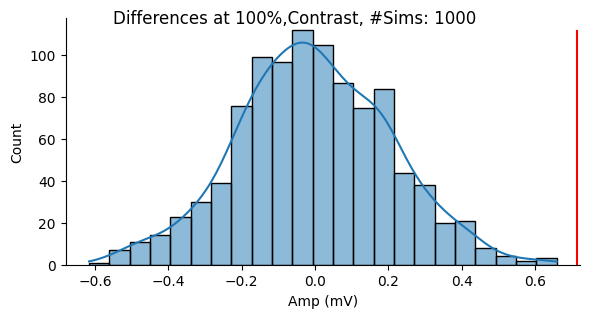

DescribeResult(nobs=1000, minmax=(-0.5309498688205263, 0.5274444488791481), mean=0.00026919160872886707, variance=0.023176137453836995, skewness=0.03779627601561007, kurtosis=0.1529895341243641)
SEM:  0.004814160098484157


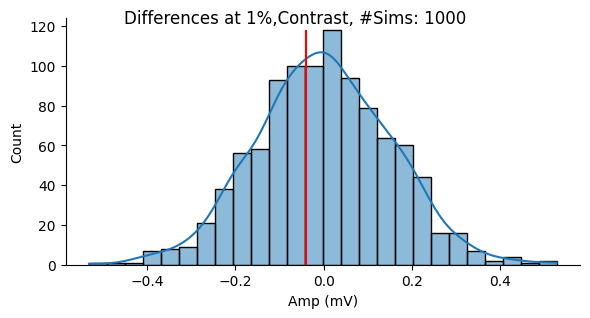

DescribeResult(nobs=1000, minmax=(-0.5094954746670864, 0.544322199606906), mean=0.0021007405331009083, variance=0.02972990763850127, skewness=-0.045395895406181344, kurtosis=-0.016382169201821117)
SEM:  0.005452513882467542


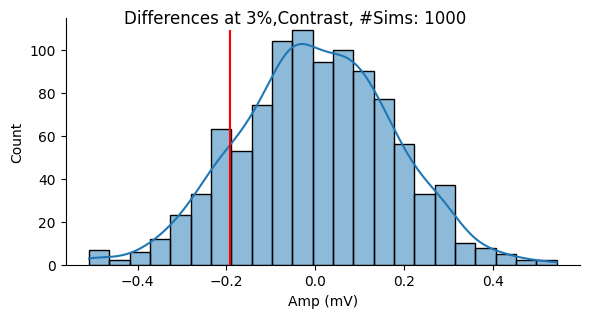

DescribeResult(nobs=1000, minmax=(-0.39268433223058785, 0.4689006262219497), mean=0.00034996072244097685, variance=0.015006497272719027, skewness=-0.06509022749157432, kurtosis=-0.03919784767014978)
SEM:  0.0038738220496970467


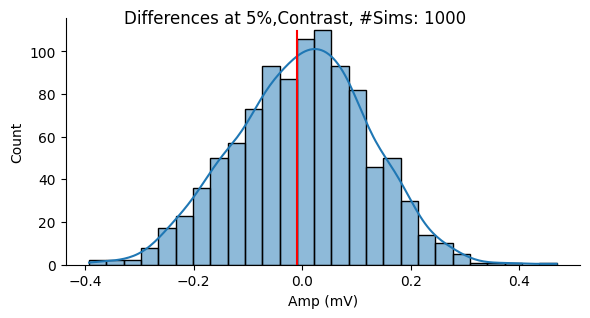

DescribeResult(nobs=1000, minmax=(-0.40976980090769166, 0.43634675786548893), mean=-0.0031370120119626177, variance=0.019719710819431423, skewness=0.06953606256963363, kurtosis=-0.08024860449960958)
SEM:  0.004440688102021062


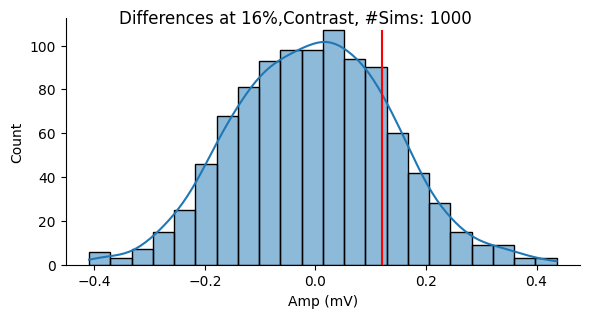

DescribeResult(nobs=1000, minmax=(-0.4790634697852856, 0.5207064305668199), mean=-0.012014758992003606, variance=0.025660256984085875, skewness=0.1716771900460071, kurtosis=-0.05638470139040841)
SEM:  0.005065595422463767


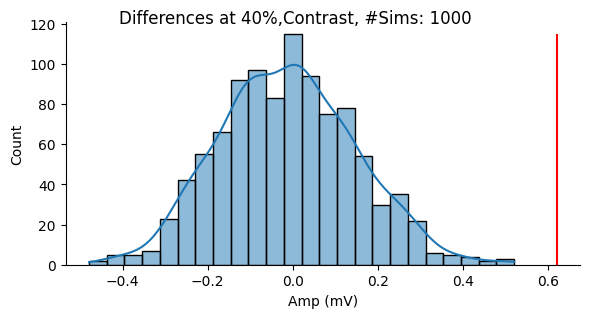

DescribeResult(nobs=1000, minmax=(-0.5619703070201676, 0.6511433255313923), mean=-0.006517028287293874, variance=0.039607969317435834, skewness=0.06520057653513892, kurtosis=-0.2067073323967139)
SEM:  0.0062934862610031835


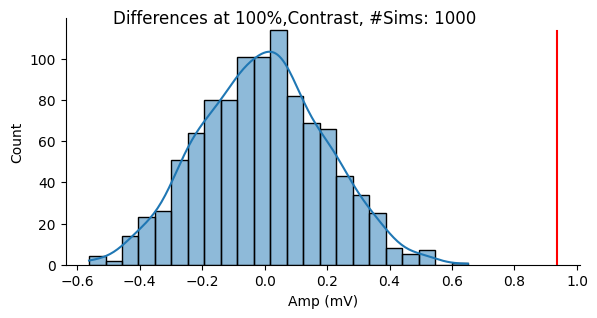

In [132]:
#print(real_diff)
cLabs=['1%', '3%', '5%', '16%', '40%', '100%','1%', '3%', '5%', '16%', '40%', '100%']
sem = dict()
SimValsPerBin = dict() # save differences per harmonic in their respective array
for var in range(NumBins*2):
   SimValsPerBin[var] = pseudo_rca_diffs[:,var]
   print(scipy.stats.describe(SimValsPerBin[var]))
   sem[var] = scipy.stats.sem(SimValsPerBin[var])
   print('SEM: ', sem[var])
   f = sns.displot(SimValsPerBin[var], kde = True, height = 3, aspect = 2)
   plt.axvline(real_diff[var],ymin=0,ymax=0.95, color = 'red')
   plt.xlabel('Amp (mV)')
   #f.fig.suptitle(f'Histogram of Harm Ind: {var+1}, Sims: {NumBoots}')
   f.fig.suptitle(f'Differences at {cLabs[var]},Contrast, #Sims: {NumBoots}')
   plt.show()

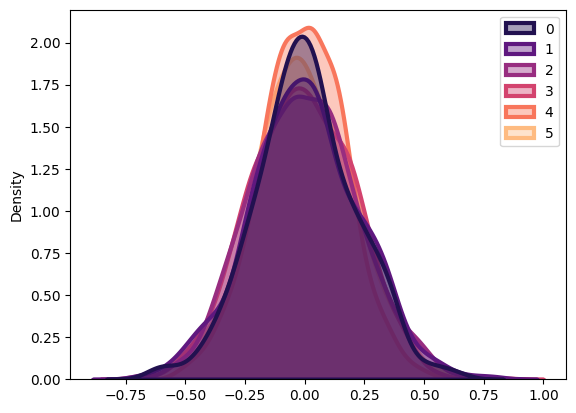

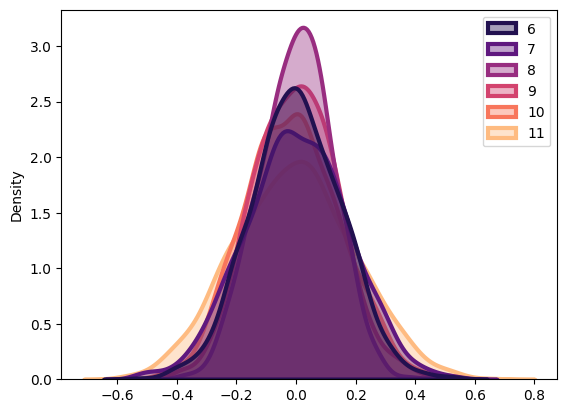

In [101]:
ind_1 = range(0,6)
f2_data = {key: SimValsPerBin[key] for key in ind_1}
ind_2 = range(6,12)
f4_data = {key: SimValsPerBin[key] for key in ind_2}
sns.kdeplot(data = f2_data, fill = True, common_norm = False, palette = 'magma', alpha = 0.40, linewidth = 3)
plt.show()
sns.kdeplot(data = f4_data, fill = True, common_norm = False, palette = 'magma', alpha = 0.40, linewidth = 3)
plt.show()

### Find What Percentile Each Aplitude Difference Lies 

In [124]:
# Combine real amplitude difference in sea of simulated data
SimArrayData = dict()

p_vals = np.zeros((NumBins*2))
for m in range(NumBins*2):
    a = real_diff[m]
    s = SimValsPerBin[m] # values generated by Numiters 
    SimArrayData = np.sort(np.append(a,s)) # add real rca diff and sort
    # find position where real_diff number belongs in simulated array ... 
    element_rank = (np.searchsorted(SimArrayData, a)) 
    TotalArrayInds = len(SimArrayData) # all simulated numbers
    percentile = (element_rank / TotalArrayInds) * 100 # multiplier
    #print(f'The amplitude difference: {a:.2f} is in the: {percentile:.2f}th percentile.')
    #print(f'{1 - percentile/100}')
    x = 1 - percentile/100
    #print(f'{x:.3f}')
    p_vals[m] = x

    # to find p val subtract by 1   - save p vals into a .pkl file
    # plot p-vals as a distribution or histogram
    # want to know: what % of particiapnts did the response amplitude significantly 
    # increase following ther ltp protocol and was there a bigger effect on F1 vs F2 and 
    # why not, did paying attention to the lfet cause more activity compared to the right?
print(p_vals)

[0.07092907 0.03596404 0.000999   0.000999   0.000999   0.000999
 0.6003996  0.85714286 0.55044955 0.19180819 0.000999   0.000999  ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DescribeResult(nobs=1000, minmax=(-0.6692036674347416, 0.6726736881184205), mean=0.0022360246382810097, variance=0.04538988516027206, skewness=0.023610356206403785, kurtosis=0.24994636291046568)
SEM:  0.0067372015822796975


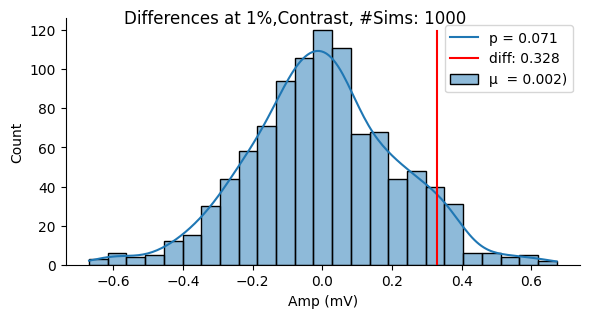

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DescribeResult(nobs=1000, minmax=(-0.7147114155203642, 0.8004993002009946), mean=0.0017277183990419252, variance=0.05295995184515547, skewness=0.08080417741459163, kurtosis=0.15198632594626726)
SEM:  0.007277358850926307


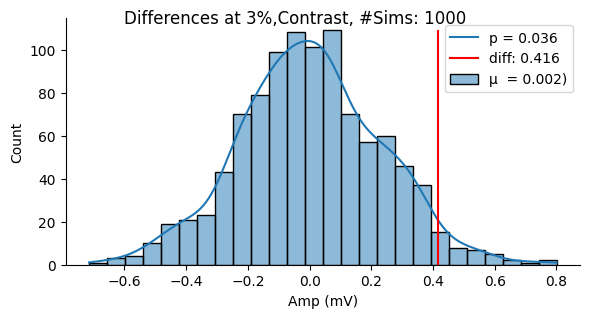

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DescribeResult(nobs=1000, minmax=(-0.6141454981977494, 0.7080456404624775), mean=-0.004892325515426293, variance=0.048427245891330656, skewness=0.13508175239475761, kurtosis=-0.18043657661222223)
SEM:  0.006958968737631364


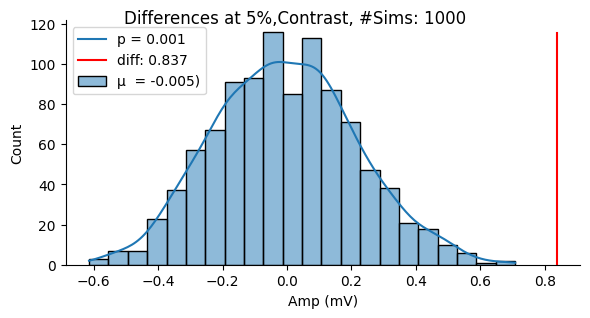

DescribeResult(nobs=1000, minmax=(-0.6934900285885801, 0.8381203944079232), mean=-0.012395442810404769, variance=0.04639341357128338, skewness=-0.018097042029434757, kurtosis=-0.12948911207110259)
SEM:  0.006811271068698072


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


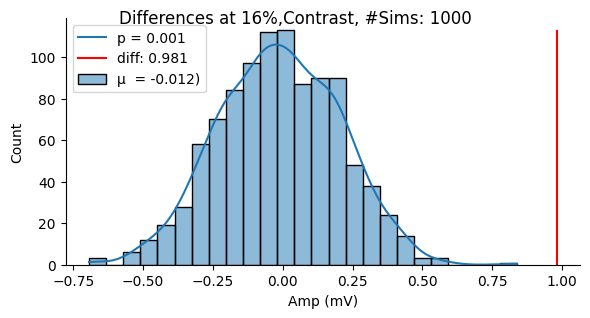

DescribeResult(nobs=1000, minmax=(-0.5343054806969558, 0.5325299710962303), mean=-0.00762899161820489, variance=0.03189080146939726, skewness=-0.05478124593538096, kurtosis=-0.03615954920526754)
SEM:  0.005647194123580068


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


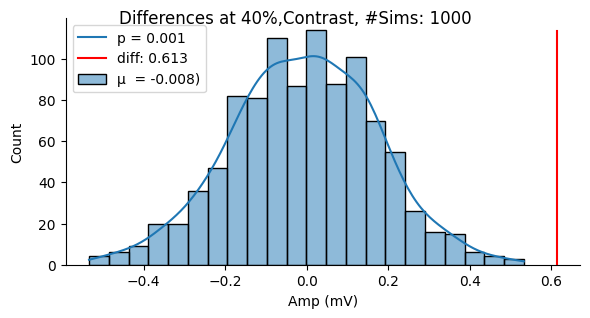

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DescribeResult(nobs=1000, minmax=(-0.6165641477336228, 0.6588542242584392), mean=-0.0038423153776454234, variance=0.043640472466271264, skewness=0.05255973571403688, kurtosis=0.006652877377487876)
SEM:  0.006606093585945575


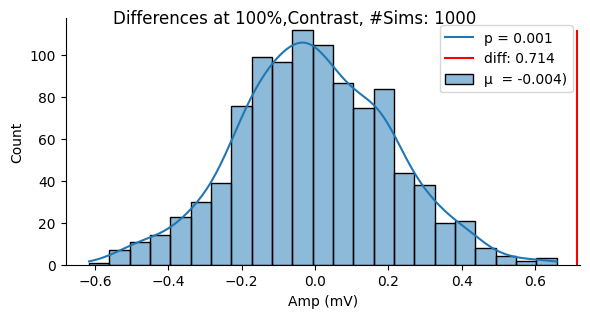

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DescribeResult(nobs=1000, minmax=(-0.5309498688205263, 0.5274444488791481), mean=0.00026919160872886707, variance=0.023176137453836995, skewness=0.03779627601561007, kurtosis=0.1529895341243641)
SEM:  0.004814160098484157


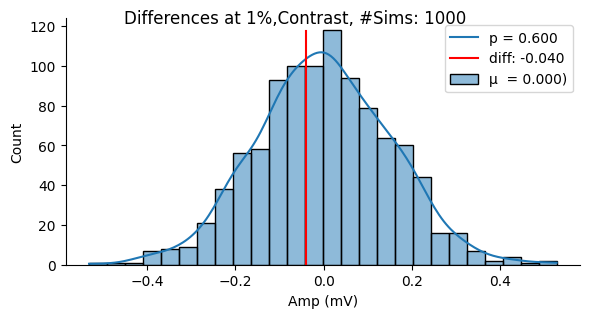

DescribeResult(nobs=1000, minmax=(-0.5094954746670864, 0.544322199606906), mean=0.0021007405331009083, variance=0.02972990763850127, skewness=-0.045395895406181344, kurtosis=-0.016382169201821117)
SEM:  0.005452513882467542


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


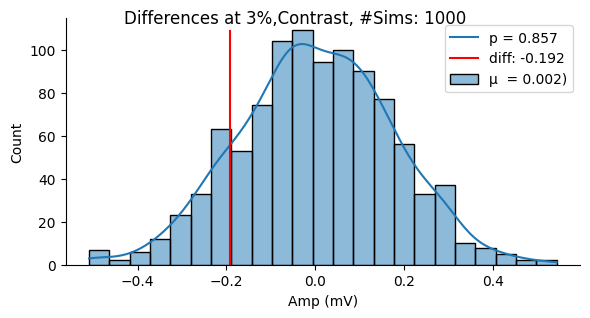

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DescribeResult(nobs=1000, minmax=(-0.39268433223058785, 0.4689006262219497), mean=0.00034996072244097685, variance=0.015006497272719027, skewness=-0.06509022749157432, kurtosis=-0.03919784767014978)
SEM:  0.0038738220496970467


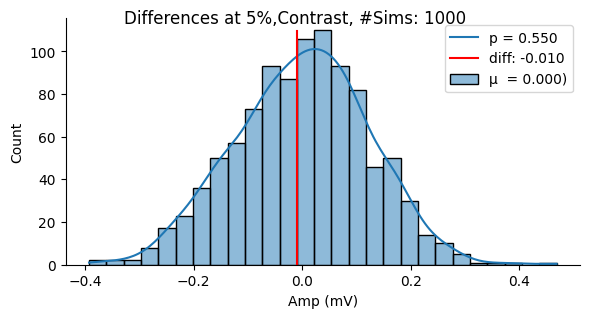

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DescribeResult(nobs=1000, minmax=(-0.40976980090769166, 0.43634675786548893), mean=-0.0031370120119626177, variance=0.019719710819431423, skewness=0.06953606256963363, kurtosis=-0.08024860449960958)
SEM:  0.004440688102021062


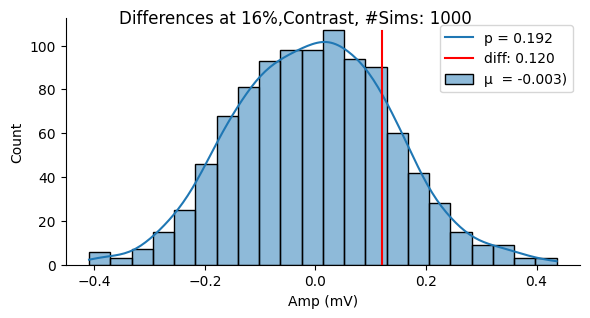

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DescribeResult(nobs=1000, minmax=(-0.4790634697852856, 0.5207064305668199), mean=-0.012014758992003606, variance=0.025660256984085875, skewness=0.1716771900460071, kurtosis=-0.05638470139040841)
SEM:  0.005065595422463767


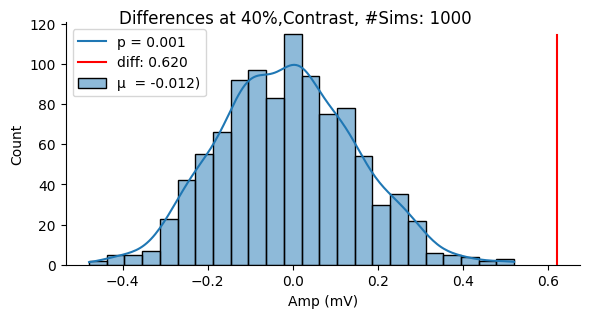

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DescribeResult(nobs=1000, minmax=(-0.5619703070201676, 0.6511433255313923), mean=-0.006517028287293874, variance=0.039607969317435834, skewness=0.06520057653513892, kurtosis=-0.2067073323967139)
SEM:  0.0062934862610031835


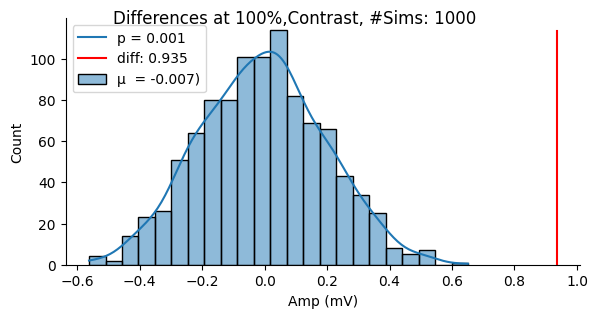

In [154]:
#print(real_diff)
cLabs=['1%', '3%', '5%', '16%', '40%', '100%','1%', '3%', '5%', '16%', '40%', '100%']
sem = dict()
SimValsPerBin = dict() # save differences per harmonic in their respective array
for var in range(NumBins*2):
   SimValsPerBin[var] = pseudo_rca_diffs[:,var]
   print(scipy.stats.describe(SimValsPerBin[var]))
   mx = scipy.stats.describe(SimValsPerBin[var])
   mu = mx[2]
   sem[var] = scipy.stats.sem(SimValsPerBin[var])
   print('SEM: ', sem[var])
   f = sns.displot(SimValsPerBin[var], kde = True, height = 3, aspect = 2)
   plt.axvline(real_diff[var],ymin=0,ymax=0.95, color = 'red')
   plt.xlabel('Amp (mV)')
   #f.fig.suptitle(f'Histogram of Harm Ind: {var+1}, Sims: {NumBoots}')
   f.fig.suptitle(f'Differences at {cLabs[var]},Contrast, #Sims: {NumBoots}')
   plt.legend(loc = 'upper left')
   plt.legend(labels=[f'p = {p_vals[var]:.3f}', f'diff: {real_diff[var]:.3f}', f'μ  = {mu:.3f})'])
   plt.show()

### Plot Data to see how the shuffles vary from the real data

In [156]:
x = sns.color_palette("Paired",12)

In [157]:
run_plots = 'N'

if run_plots == 'Y':

#### Plot real CRF data from RCA 
    fig, axs = plt.subplots(2, NumHarms, figsize=(9, 6), sharey = True)
    title = f'Real RCA CRF'
# 2F1
    axs[0,0].plot(real_rca[:6,0], 'o', markersize = 8, label = 'Pre 2F1', color = x[4])
    axs[0,0].plot(real_rca[:6,1], 'o',markersize = 8,  label = 'Post 2F1', color = x[5])
    axs[0,0].legend(fontsize = 7, loc = 'lower right')
    axs[0,0].spines['top'].set_visible(False)
    axs[0,0].spines['right'].set_visible(False)
    axs[0,0].set_ylabel('Response (R)')
    axs[0,0].set_xlabel('Contrast Increase')
# 4F1
    axs[0,1].plot(real_rca[6:,0], 'o',markersize = 8,  label = 'Pre 4F1', color = x[4])
    axs[0,1].plot(real_rca[6:,1], 'o', markersize = 8,  label = 'Post 4F1', color = x[5])
    axs[0,1].legend(fontsize = 7, loc = 'lower right')
    axs[0,1].spines['top'].set_visible(False)
    axs[0,1].spines['right'].set_visible(False)
    axs[0,1].set_ylabel('Response (R)')
    axs[0,1].set_xlabel('Contrast Increase')
    plt.suptitle('Real CRF', fontsize=18)

# plot the difference between pre and post conditions
    plt.show()
else:
    print('Too much data to plot - reduce size or something')

Too much data to plot - reduce size or something


#### Viz for what boot data looks like compared to real data

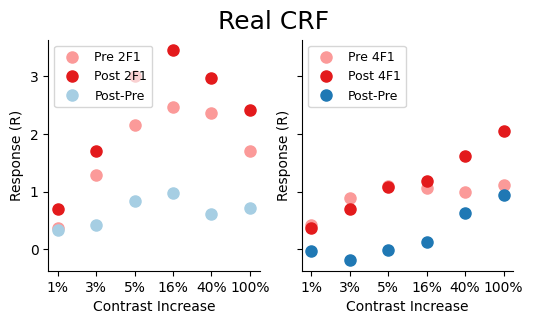

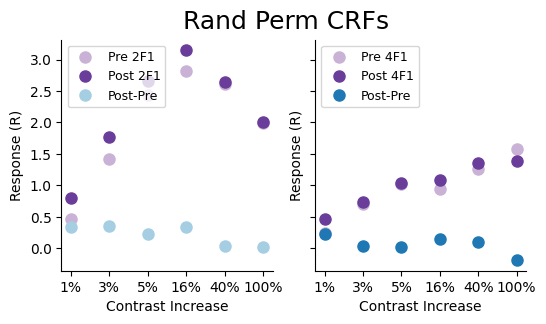

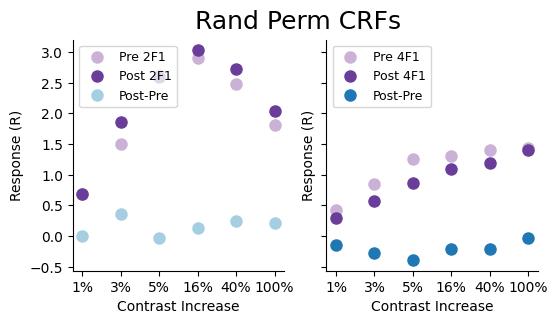

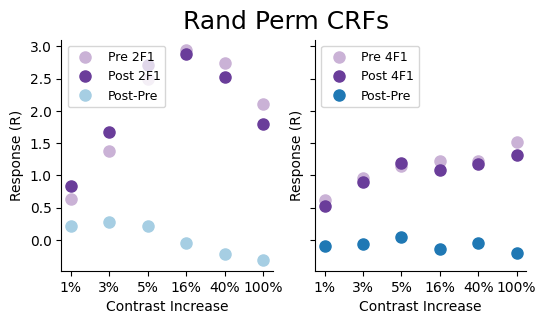

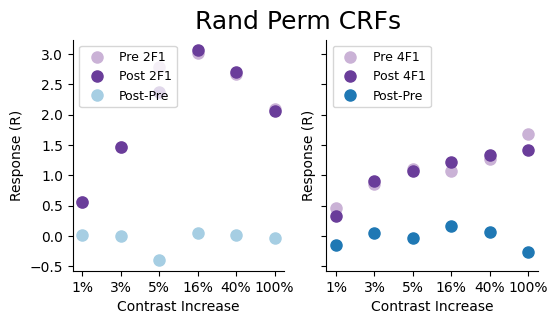

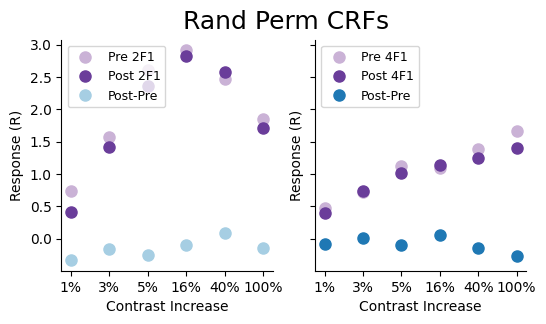

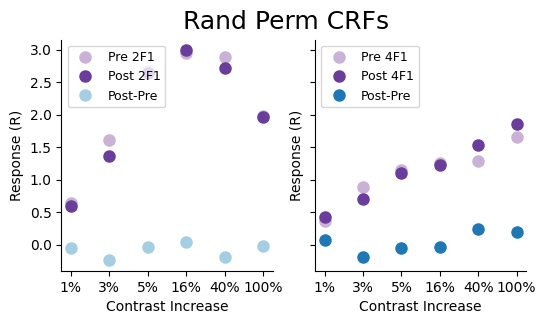

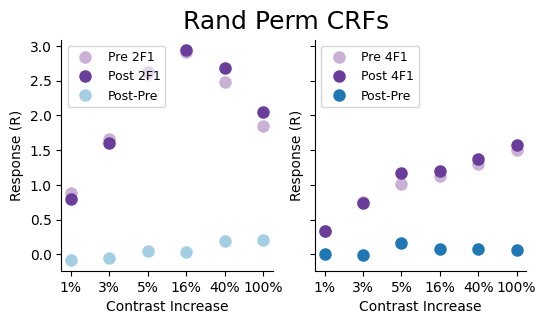

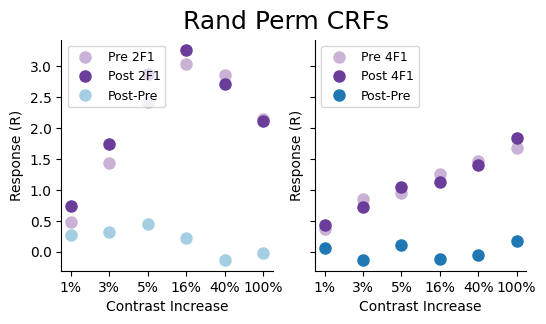

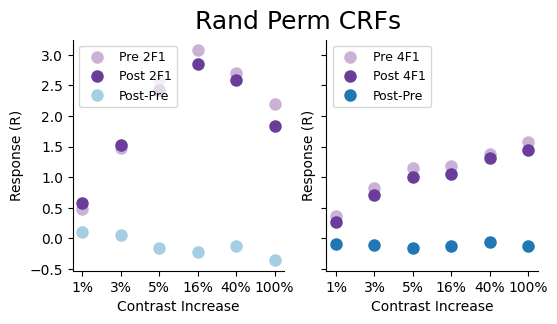

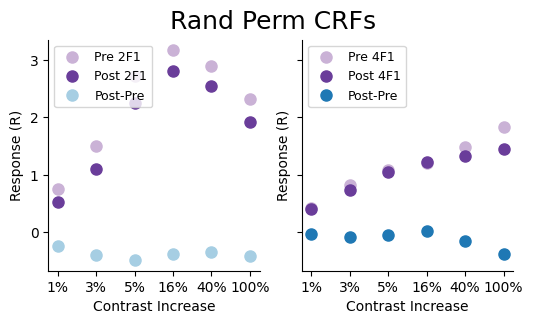

In [169]:
#### Plot real CRF data from RCA 
fig, axs = plt.subplots(1, NumHarms, figsize=(6, 3), sharey = True)
title = f'Real RCA CRF'
# 2F1
axs[0].plot(real_rca[:6,0], 'o', markersize = 8, label = 'Pre 2F1', color = x[4])
axs[0].plot(real_rca[:6,1], 'o',markersize = 8,  label = 'Post 2F1', color = x[5])
axs[0].plot((real_rca[:6,1]-real_rca[:6,0]), 'o',markersize = 8,  label = 'Post-Pre', color = x[0])
axs[0].legend(fontsize = 9, loc = 'upper left')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_ylabel('Response (R)')
axs[0].set_xlabel('Contrast Increase')
# 4F1
axs[1].plot(real_rca[6:,0], 'o',markersize = 8,  label = 'Pre 4F1', color = x[4])
axs[1].plot(real_rca[6:,1], 'o', markersize = 8,  label = 'Post 4F1', color = x[5])
axs[1].plot((real_rca[6:,1]-real_rca[6:,0]), 'o',markersize = 8,  label = 'Post-Pre', color = x[1])

axs[1].legend(fontsize = 9, loc = 'upper left')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_ylabel('Response (R)')
axs[1].set_xlabel('Contrast Increase')
axs[1].set_xticks(range(6))
axs[1].set_xticklabels(cLabs)
axs[0].set_xticks(range(6))
axs[0].set_xticklabels(cLabs)

plt.suptitle('Real CRF', fontsize=18)
plt.show()

run_plots = 'Y'

cLabs=['1%', '3%', '5%', '16%', '40%', '100%']
if run_plots == 'Y':
#### Plot generated data from shuffling 
    for iter in range(10):#(len(shuffs.keys())):#(len(rcaData)):
        fig, axs = plt.subplots(1, NumHarms, figsize=(6, 3), sharey = True)
        title = f'F1_SubNumBoots_{iter+1}.png'
    # 2F1 
        axs[0].plot(psuedo_rca[iter][:6,0], 'o', markersize = 8, label = 'Pre 2F1', color = x[8])
        axs[0].plot(psuedo_rca[iter][:6,1], 'o',markersize = 8,  label = 'Post 2F1', color = x[9])

        axs[0].plot((psuedo_rca[iter][:6,1]-psuedo_rca[iter][:6,0]), 'o',markersize = 8,  label = 'Post-Pre', color = x[0])

        axs[0].legend(fontsize = 9, loc = 'upper left')
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        axs[0].set_ylabel('Response (R)')
        axs[0].set_xlabel('Contrast Increase')
    # 4F1 
        axs[1].plot(psuedo_rca[iter][6:,0], 'o',markersize = 8,  label = 'Pre 4F1', color = x[8])
        axs[1].plot(psuedo_rca[iter][6:,1], 'o', markersize = 8,  label = 'Post 4F1', color = x[9])

        axs[1].plot((psuedo_rca[iter][6:,1]-psuedo_rca[iter][6:,0]), 'o',markersize = 8,  label = 'Post-Pre', color = x[1])

        axs[1].legend(fontsize = 9, loc = 'upper left')
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        axs[1].set_ylabel('Response (R)')
        axs[1].set_xlabel('Contrast Increase')
        axs[1].set_xticks(range(6))
        axs[1].set_xticklabels(cLabs)
        axs[0].set_xticks(range(6))
        axs[0].set_xticklabels(cLabs)
        plt.suptitle('Rand Perm CRFs', fontsize=18)
        FilePath = os.path.join(SaveFigDir, title)
        plt.savefig(FilePath)
        plt.show()

else:
    print('Will take long ...too much data to plot - fix range() in loop first!!!')

# 10k values and then sort of difference and where is the actual change - to find significant difference
# 1k values - whats mean and std of difference pre and post shuffled - mean of change - but std may be different - f change was different the rca data was - can get p value in terms of std

# get difference btwn simulated and real data and then  - rank the real data placement based on where it lies within the simulated data - will do this 6 times bc of the differnce between pre and post - 

### Preparation for Bootstrapping